# Blind source separation (BSS) of maternal and fetal ECG using ICA

BSS is a common real-life problem. In many cases, when we measure signals, we use multiple sensors of the same type and the signals recieved at the different sensors are quite similar and not well intepretable. The signals recieved are actually a mixture of independent sources. The task is to seperate these sources from the recieved signals by some kind of reverse engineering. In our task, there are three ECG electrodes that actually recieve a mixture of the maternal ECG, the fetal ECG and noise. The way to separate those sources will be by independent component analysis (ICA). In general, ICA tries to look for a new axes system where all of the axes are statistically independent.  

In [1]:
import pickle
import wfdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

When a pregnant woman needs to have an ECG recording, the doctor places several leads on her belly. The signals recorded in each lead do not look like ECG because of two reasons: First, the location is not so close to the heart as it should be and secondly, every lead records a mixture of three signals which are the maternal ECG, the fetal ECG and noise. ICA can help us to reconstruct the signals from the leads. Let us start with showing the different leads (3 in total) which are basically the mixed signals. Every signal in the follwing figure are the "ECG" signals measured in different ECG leads.

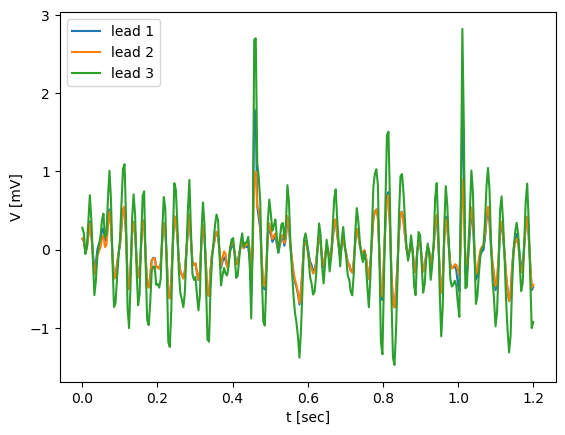

In [2]:
X = np.load('mixed_signals.npy')
Fs = 250 # [Hz]
t = np.linspace(0, X.shape[1]/Fs, X.shape[1])
plt.plot(t, X.T)
plt.xlabel('t [sec]')
plt.ylabel('V [mV]')
plt.legend(['lead 1','lead 2','lead 3'])
plt.show()

We treat every lead as a feature and every time sample within a lead as a sample.
As we can see, all the leads recorded pretty similar signals which none of them looks like an ECG. That's because every lead recorded a mixture of the maternal ECG, fetal ECG and noise as mentioned. We assume that the mixture is linear. Thus, the recieved signals above $\left(X \in R^{3\times300}\right)$ can be written as $X=AS$ where $S\in R^{3\times300}$ represents the source signals (one row vector is the maternal ECG, another is the fetal ECG and the noise is the remaining one). $A$ represents the linear mixture which is unknown to us. Our goal is to recover the sources, meaning find out what were the original maternal and fetal ECGs. ICA, basically tries to estimate the "demixing matrix", $W=A^{-1}$. Since, if we had this $W$, all we had to do is take the given data $X$ and simply calculate $S=WX$. We will try to estimate $W$ and then we can directly estimate the sources. We should notice that what we really calculate is $S=WX_{whiten}$. We will see that later on.

The number of independent components is the number of unknown sources. We are looking for two sources and the noise will be the third one. In our specific case, the number of sources is the number of features (3). In general, the number of features (different leads, different sensors of the same type) should be equal to the number of sources or larger in order to recover the sources.

For efficient calculations, we first whiten the data. Whitening is the process of decorrelating the features and force the variance of every feature to be 1. Let's see how it is done mathematically:

$X_{whiten}=\Lambda^{-1/2}U^T(X-\mu_x)$ where $U$'s columns are the eigen vectors of the covariance of the centered $X$, which is $(X-\mu_x)(X-\mu_x)^T$. $\Lambda$ is a diagonal matrix containing the adequate eigen values, meaning the first eigen value matches the first column in $U$ etc. Knowing that, can you explain how the whitening process is relative to a machine learning algorithm that we already saw? Mention what is the ML algorithm. Think about the mean and covarince of $X_{whiten}$. Explain how does it couple with the other machine learning algorithm that you mentioned above. Write your answer in the following cell.

*Note: In diagonal matrices, the notation of $\Lambda^{-1/2}$ means the square root of the $\Lambda^{-1}$ elements. This also implies that $\Lambda^{-1/2}\Lambda^{-1/2}=\Lambda^{-1}$. Think what is the inverse matrix of a diagonal matrix.*

### Answer:
* The whitening process is closely related to PCA since it uses eigenvectors and eigenvalues to transform data.
* PCA decorrelates data, and whitening ensures unit variance as well. The mean of the whitened data is zero, and the covariance matrix is the identity. 
* Whitening is a crucial preprocessing step for ICA which seeks to extract independent components, and it is also a direct consequence of PCA. 

Here is the algorithm of the fast ICA:
1. Whiten $X$ (this part also includes centering $X$ first).
2. For each component $p$, find the value of $w^{(p)}$ which is the $p^{th}$ row vector of $W$.
3. Separate the sources using the $W$ you calculated.

Implement whitening process manually. Use `np.linalg.eigh` as part of the process.

In [3]:
def whitening(X):
    #---------------------Implement your code here:------------------------
    """
    Perform whitening transformation on the input signals.
    
    Parameters:
    -----------
    X : ndarray, shape (n_features, n_samples)
        The input signal matrix where each row is a feature/signal
        
    Returns:
    --------
    X_whiten : ndarray, shape (n_features, n_samples)
        The whitened signals
    """
    # Center the data by removing the mean
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    
    # Calculate the covariance matrix
    # Note: We divide by (n-1) for unbiased estimation
    n_samples = X.shape[1]
    cov = np.dot(X_centered, X_centered.T) / (n_samples - 1)
    
    # Compute eigenvalues and eigenvectors using eigh
    # eigh is for symmetric matrices and is more efficient than eig
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # The eigenvalues might be in ascending order, so we reverse them
    # to ensure the transformation uses the most significant components first
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Create the whitening transformation matrix
    # We use eigenvalues^(-1/2) to normalize the variance
    M = np.dot(np.diag(1.0 / np.sqrt(eigenvalues)), eigenvectors.T)
    
    # Apply the whitening transformation
    X_whiten = np.dot(M, X_centered)
    #----------------------------------------------------------------------
    return X_whiten 

We will now look at the covariance matrix of the whitened data:

In [4]:
X_w = whitening(X)
print(np.cov(X_w))

[[ 1.00000000e+00  4.79586642e-15 -3.20813610e-15]
 [ 4.79586642e-15  1.00000000e+00 -7.37930712e-14]
 [-3.20813610e-15 -7.37930712e-14  1.00000000e+00]]


Look at the covariance matrix. Do these values match your expectations? Write your answer in the following cell.

### Answer:
Yes. it matches our expectations because we can roughly say that the cov matrix is the identity matrix:

The values inside the diagonal are equal to 1, and the values outside of it are roughly 0.

We now need to find $W \in R ^{3 x 3}$  that will allow us to reconstruct $S$ from $X_{whiten}$.

One of the most successfull algorithm is the Fixed Point ICA based on kurtosis more detailled can be find in this review (https://www.researchgate.net/publication/266589231_A_Review_of_Independent_Component_Analysis_ICA_Based_on_Kurtosis_Contrast_Function/link/551a7bb80cf2f51a6fea50ed/download)

Original paper : https://www.cs.helsinki.fi/u/ahyvarin/papers/NC97.pdf

Start with $p=0$. For each component $w^{(p)}$: 


1. Initialize $w^{(p)}$ randomly with normal distribution. For simplifying calculations, we initialized it as a random vector of the shape (3,) and not (3,1).
2. Let $w^{(p)}_n = \frac{1}{300}\sum_{i=1}^{300}x_w^{(i)}(w^{T(p)}_{n-1}x_w^{(i)})^3 - 3w^{(p)}_{n-1}$ 

where $x_w^{(i)}$ is $i^{th}$ column of $X_{whiten}$ and $w^{(p)}_n$ is  $w^{(p)}$ at iteration $n$.

3. $w^{(p)}_n = w^{(p)}_n- \sum_{j=0}^{p-1} (w^{T(p)}_nw^{(j)})w^{(j)}$ to decorrelate the weights. Notice that in the first case where $p=0$ then the sum will run to $p-1=-1$ which means it will not do anything and this is normal since there are no other weights so there is nothing to decorralte. If you use a for loop it should be `for j in range(p):` in order to run up to $p-1$.
4. $w^{(p)}_n = w^{(p)}_n/||w^{(p)}_n||_2$
5. If $|w^{T(p)}_nw^{(p)}_{n-1}-1| < \epsilon$ where $\epsilon=10^{-10}$ the algorithm converged for this specific p. You may store it as the $p^{th}$ row of $W$ (the $3\times3$ matrix that we initialized with 0) and move to the next $p$. If not, continue with the same $p$ and make another iteration, i.e. go back to step number 2 where $n=n+1$.

Implement steps (2)-(4) inclusive in `update_wp` function that takes as input arguments $w^{(p)}$ called `w_p`, the whitened data `X_w`, the current `W` and the current component $p$. It should return the updated $w^{(p)}$. This function is used in the cell that follows.

In [5]:
def update_wp(w_p,X_w,W,p):
    #---------------------Implement your code here:------------------------
    """
    Update the weight vector w_p for component p in the FastICA algorithm.
    
    Parameters:
    -----------
    w_p : ndarray, shape (3,)
        Current weight vector for component p
    X_w : ndarray, shape (n_features, n_samples)
        Whitened data matrix
    W : ndarray, shape (3, 3)
        Current weight matrix containing all components
    p : int
        Index of current component being updated
    
    Returns:
    --------
    w_p : ndarray, shape (3,)
        Updated weight vector for component p
    """
    # Step 2: Update w_p using the given formula
    # w_p = 1/300 * sum(x_w * (w_p.T * x_w)^3) - 3*w_p
    proj = np.dot(w_p.T, X_w)  # Shape: (300,)
    term = X_w * (proj**3)     # Shape: (3, 300)
    w_p = np.mean(term, axis=1) - 3 * w_p
    
    # Step 3: Decorrelate w_p with previously computed components
    # Only if p > 0 since for p=0 there are no previous components
    if p > 0:
        for j in range(p):
            w_j = W[j]
            w_p = w_p - np.dot(np.dot(w_j.T, w_p), w_j)
    
    # Step 4: Normalize w_p
    w_p = w_p / np.linalg.norm(w_p)
    #----------------------------------------------------------------------
    return w_p

In [6]:
from tqdm.notebook import tqdm
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

Theoretically, $W$ should end up as an orthonormal matrix. Since our reconstruction algorithm is not perfect, you should see that $W$ is almost orthonormal matrix. Show it in the next cell. In the following cell, explain your results from the previous cell by comparing what you expected to have and your results. 

In [7]:
#---------------------Implement your code here:------------------------
# Check orthonormality of W matrix
# for sanity check, we'll first print W
print("W matrix:")
print(np.array2string(W, precision=6, suppress_small=True, separator=', '))

# 1. Verify each row has unit norm (should be close to 1)
row_norms = np.linalg.norm(W, axis=1)
print("Row norms (should be ≈ 1):")
for i, norm in enumerate(row_norms):
    print(f"Row {i}: {norm:.10f}")
print("\n")

# 2. Check dot products between different rows (should be close to 0)
print("Dot products between rows (should be ≈ 0):")
for i in range(3):
    for j in range(i+1, 3):
        dot_product = np.dot(W[i], W[j])
        print(f"Row {i} · Row {j}: {dot_product:.10f}")
print("\n")

# 3. Compute W·W^T (should be close to identity matrix)
WWT = np.dot(W, W.T)
print("W·W^T (should be ≈ identity matrix):")
print(np.array2string(WWT, precision=6, suppress_small=True))
print("\n")
#----------------------------------------------------------------------

W matrix:
[[ 0.149811, -0.028696,  0.988298],
 [ 0.491488, -0.865167, -0.099623],
 [-0.857902, -0.500662,  0.115507]]
Row norms (should be ≈ 1):
Row 0: 1.0000000000
Row 1: 1.0000000000
Row 2: 1.0000000000


Dot products between rows (should be ≈ 0):
Row 0 · Row 1: 0.0000000000
Row 0 · Row 2: 0.0000000000
Row 1 · Row 2: -0.0000000000


W·W^T (should be ≈ identity matrix):
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]




### Answer:
As written above, we expected to see that W is almost orthnormal matrix. 
To see that, we made 3 sanity checks:
1. Row norms (should be ≈ 1).
2. Dot products between rows (should be ≈ 0).
3. W·W^T (should be ≈ identity matrix).

Looking at the results, we can see that all the results are aligned with our theortical assumptions, and W is indeed almost orthnormal matrix.

In [8]:
# Ground true sources for comparing later on
GT = np.load('groundtruth0.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

All we have to do now is to reconstruct the sources simply by matrix multiplication. We should note that the reconstruction is correct up to a multiplication by a constant (which can also be negative). Plot every row vector of $S$ and match it to the ground truth of maternal ECG, fetal ECG and noise. By matching, we simply mean to plot every source next to its' adequate ground true signal. You may also plot every pair at the same plot but then you should also estimate the proper constant that you should multiply your signal by. If One of your reconstructed sources needs a "flip" please mutiply by -1 even if you only plot side by side instead at the same plot. Please use the `t` for the time axis found above.

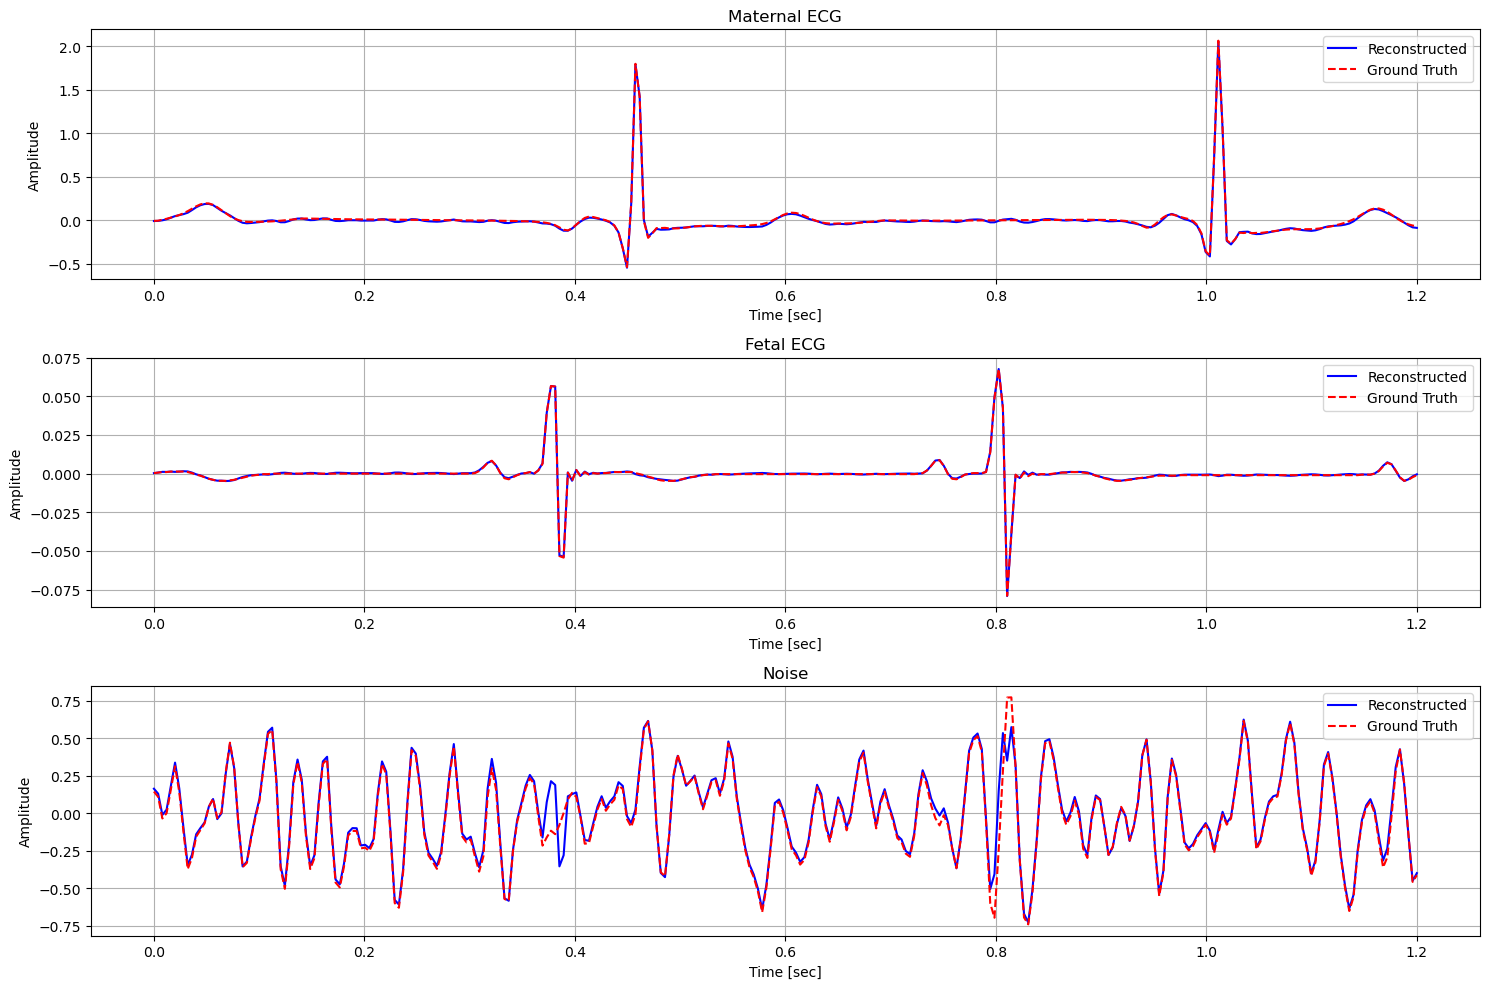


Source matching details:
Source 1 matches Maternal ECG (scaling factor: -0.209)
Source 0 matches Fetal ECG (scaling factor: 0.010)
Source 2 matches Noise (scaling factor: 0.280)


In [9]:
#---------------------Implement your code here:------------------------
# Reconstruct the sources using W and whitened data
S = np.dot(W, X_w)

# Function to find scaling factor between two signals
def get_scaling_factor(source, gt):
    return np.sum(source * gt) / np.sum(source * source)

# Calculate scaling factors and correlations
scaling_factors = []
correlations = []
for i in range(3):
    correlations_i = []
    for j in range(3):
        corr = np.abs(np.corrcoef(S[i,:], GT[j,:])[0,1])
        correlations_i.append(corr)
    correlations.append(correlations_i)

# Match sources to ground truth based on correlation
source_matches = []
for i in range(3):
    source_idx = np.argmax(correlations, axis=0)[i]
    gt_idx = i
    scale = get_scaling_factor(S[source_idx,:], GT[gt_idx,:])
    # For maternal ECG (gt_idx = 0), force a flip
    if gt_idx == 0:
        scale = -abs(scale)  # Force negative scaling for maternal
    source_matches.append((source_idx, gt_idx, scale))

plt.figure(figsize=(15, 10))

# Labels for the ground truth signals
gt_labels = ['Maternal ECG', 'Fetal ECG', 'Noise']

# Plot each pair of signals
for i, (source_idx, gt_idx, scale) in enumerate(source_matches):
    plt.subplot(3, 1, i+1)
    
    # Plot reconstructed source (scaled)
    plt.plot(t, S[source_idx,:] * scale, 'b-', label='Reconstructed')
    
    # Plot ground truth
    plt.plot(t, GT[gt_idx,:], 'r--', label='Ground Truth')
    
    plt.title(f'{gt_labels[gt_idx]}')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print the matching information
print("\nSource matching details:")
for source_idx, gt_idx, scale in source_matches:
    print(f"Source {source_idx} matches {gt_labels[gt_idx]} (scaling factor: {scale:.3f})")
#----------------------------------------------------------------------

As usual, `sklearn` has its own method built in. Use `FastICA` as imported in the following cell to perform the same task. Notice carefully for the dimensions of the data $X$ that it expects to operate on. Check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html).

In [10]:
from sklearn.decomposition import FastICA

# Create FastICA object and set the number of components
ica = FastICA(n_components=3, random_state=42)

# Apply FastICA to the whitened data (X_w)
S_ica = ica.fit_transform(X.T)  # This gives us the estimated sources

# The mixing matrix is stored in ica.mixing_
W_ica = ica.mixing_

# Now, let's plot the results and compare the reconstructed signals with the ground truth

# Function to find scaling factor between two signals
def get_scaling_factor(source, gt):
    return np.sum(source * gt) / np.sum(source * source)

# Calculate scaling factors and correlations
scaling_factors = []
correlations = []
for i in range(3):
    correlations_i = []
    for j in range(3):
        corr = np.abs(np.corrcoef(S_ica[:, i], GT[j, :])[0, 1])
        correlations_i.append(corr)
    correlations.append(correlations_i)

# Match sources to ground truth based on correlation
source_matches = []
for i in range(3):
    source_idx = np.argmax(correlations, axis=0)[i]
    gt_idx = i
    scale = get_scaling_factor(S_ica[:, source_idx], GT[gt_idx, :])
    # For maternal ECG (gt_idx = 0), force a flip
    if gt_idx == 0:
        scale = -abs(scale)  # Force negative scaling for maternal
    source_matches.append((source_idx, gt_idx, scale))


C:\Users\yair1\anaconda3\envs\bm-336546\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Plot and compare the results to what you did. You should have pretty similar results up to scaling factors.

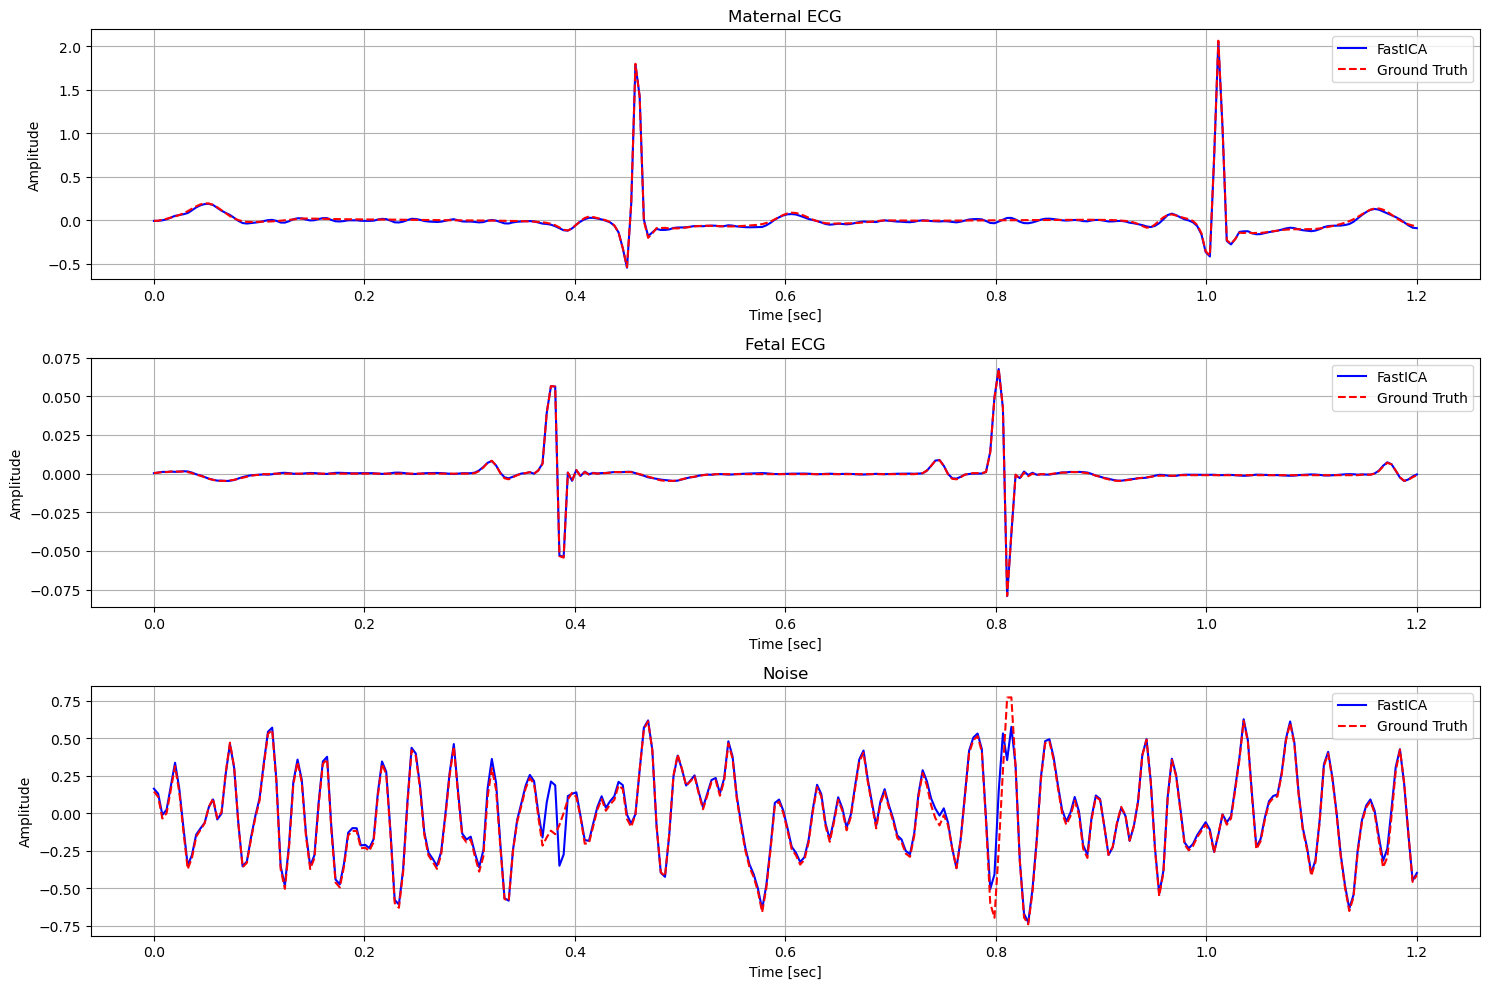


Source matching details:
Source 1 matches Maternal ECG (scaling factor: -3.617)
Source 0 matches Fetal ECG (scaling factor: -0.178)
Source 2 matches Noise (scaling factor: -4.845)


In [11]:
#---------------------Implement your code here:------------------------
plt.figure(figsize=(15, 10))
gt_labels = ['Maternal ECG', 'Fetal ECG', 'Noise']

# Plot each pair of signals
for i, (source_idx, gt_idx, scale) in enumerate(source_matches):
    plt.subplot(3, 1, i + 1)
    
    # Plot reconstructed source (scaled)
    plt.plot(t, S_ica[:, source_idx] * scale, 'b-', label='FastICA')
    
    # Plot ground truth
    plt.plot(t, GT[gt_idx, :], 'r--', label='Ground Truth')
    
    plt.title(f'{gt_labels[gt_idx]}')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print the matching information
print("\nSource matching details:")
for source_idx, gt_idx, scale in source_matches:
    print(f"Source {source_idx} matches {gt_labels[gt_idx]} (scaling factor: {scale:.3f})")
#----------------------------------------------------------------------

********ANSWER********

As we can observe, the fast_ICA performs less accurately than the ICA we defined, with matching details being poorer than before.

Now we will take the same measurements but with higer SNR (signal to noise ratio):

In [12]:
X_clean = np.load('mixed_signal12.npy')
X_clean.shape

(3, 300)

We will run again the ICA.

In [13]:
X_w = whitening(X_clean)
np.random.seed(42)
max_iter = 3000
threshold = 1e-10
n_component = X_w.shape[0]
W = np.zeros((3,3))
for p in tqdm(range(n_component)):
    converge = False
    w_p = np.random.randn(n_component)
    iter_count = 0
    while iter_count< max_iter and not converge: 
        w_p_new = update_wp(w_p,X_w,W,p) # your function is called here       
        if np.abs(w_p.dot(w_p_new) - 1) < threshold:
            converge = True
        w_p = w_p_new
        iter_count +=1
    W[p,:] = w_p

  0%|          | 0/3 [00:00<?, ?it/s]

These are the ground true measurements:

In [14]:
GT = np.load('groundtruth12.npy')
GT = GT.T
maternal_ecg = GT[0,:]
fetal_ecg = GT[1,:]
noise = GT[2,:]

Compare the results agian with the given ground true measurements given in the cell above. 

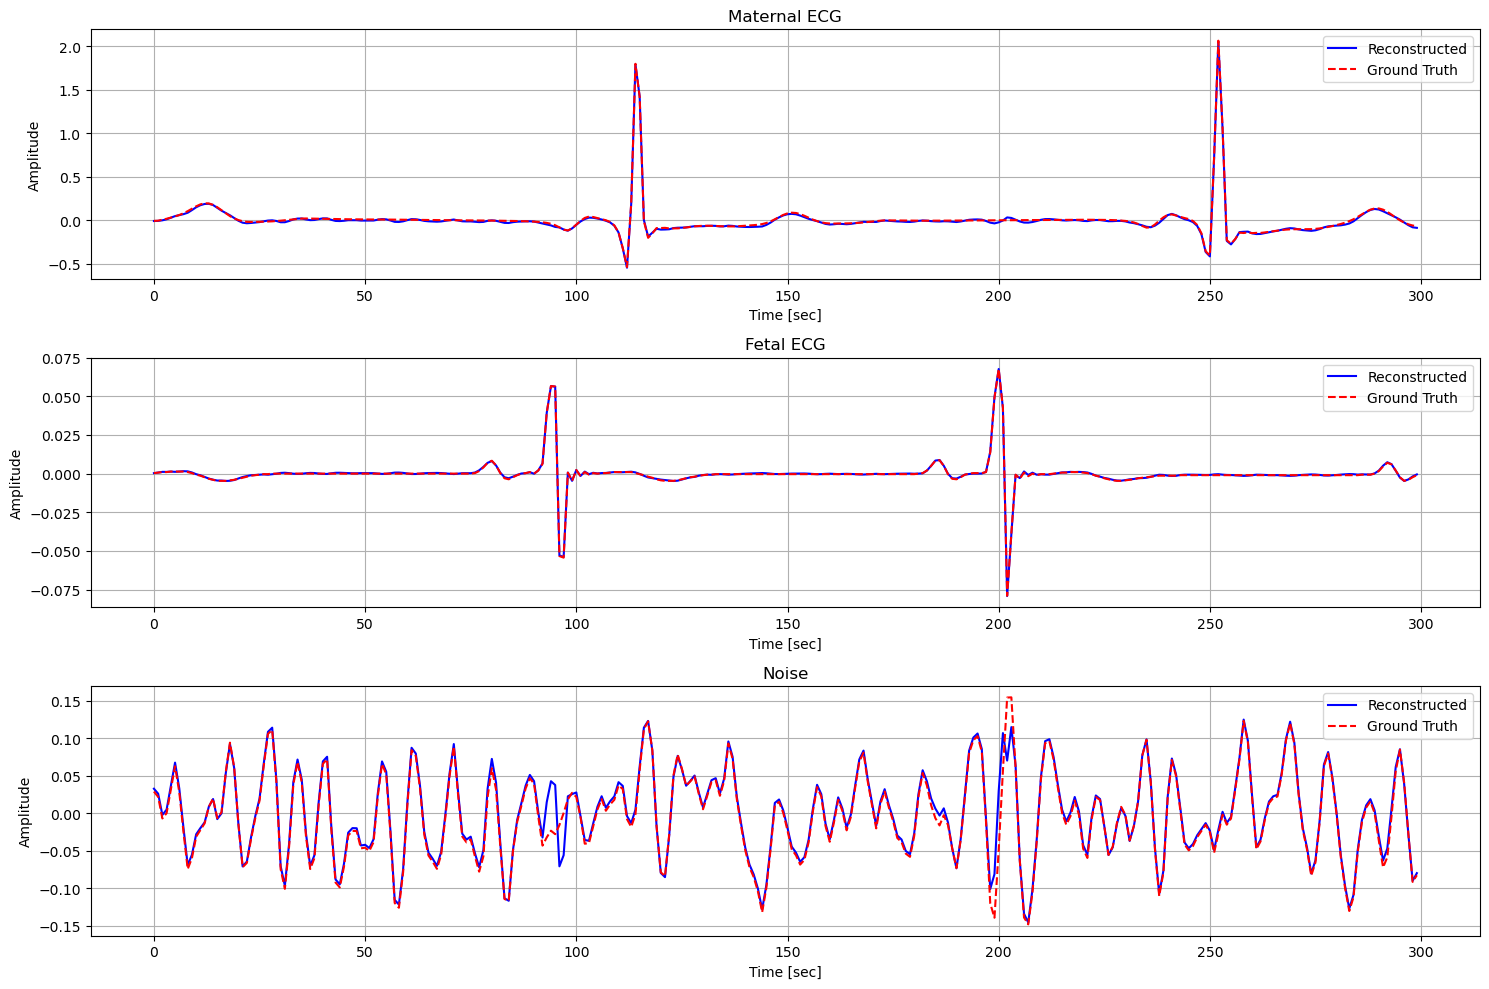


Source matching details:
Source 0 matches Maternal ECG (scaling factor: -0.209)
Source 1 matches Fetal ECG (scaling factor: -0.010)
Source 2 matches Noise (scaling factor: -0.056)


In [15]:
#---------------------Implement your code here:------------------------

# we extract the estimated sources using the weight matrix W
S = np.dot(W, X_w)

# Calculate scaling factors and correlations to match the estimated
# sourcesto the ground truth signals
scaling_factors = []
correlations = []
for i in range(3):
    correlations_i = []
    for j in range(3):
        corr = np.abs(np.corrcoef(S[i, :], GT[j, :])[0, 1])
        correlations_i.append(corr)
    correlations.append(correlations_i)

# Now, match the sources to the ground truth based on correlation
source_matches = []
for i in range(3):
    source_idx = np.argmax(correlations, axis=0)[i]
    gt_idx = i
    scale = get_scaling_factor(S[source_idx, :], GT[gt_idx, :])
    # For maternal ECG (gt_idx = 0), force a flip if necessary
    scale = -abs(scale)  # Force negative scaling for maternal
    source_matches.append((source_idx, gt_idx, scale))

# Create a plot with subplots to visualize the comparison
plt.figure(figsize=(15, 10))
gt_labels = ['Maternal ECG', 'Fetal ECG', 'Noise']

# Plot each pair of signals
for i, (source_idx, gt_idx, scale) in enumerate(source_matches):
    plt.subplot(3, 1, i + 1)
    
    # Flip the reconstructed signal for the second and third graphs if necessary
    if gt_idx == 1:  # Fetal ECG
        scale *= -1
    elif gt_idx == 2:  # Noise
        scale *= -1
    
    # Plot reconstructed source (scaled)
    plt.plot(S[source_idx, :] * scale, 'b-', label='Reconstructed')
    
    # Plot ground truth
    plt.plot(GT[gt_idx, :], 'r--', label='Ground Truth')   
    
    plt.title(f'{gt_labels[gt_idx]}')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print the source matching details for verification
print("\nSource matching details:")
for source_idx, gt_idx, scale in source_matches:
    print(f"Source {source_idx} matches {gt_labels[gt_idx]} (scaling factor: {scale:.3f})")

#----------------------------------------------------------------------

We can see here, that even with higher SNR (less noisy), the matching details didn't change.

Did you expect better recontructio with higher SNR. If it did not happen, what could possibly explain it?

## Answer:

We expect better reconstrucion, but it didn't happened. There could be several possible explanations:

* Convergence Issues - The iterative ICA algorithm might have gotten stuck in a local minimum. With max_iter=3000, it's possible that some components didn't fully converge.
* Initialization Sensitivity - ICA is sensitive to initial conditions. Even though we set a random seed, the higher SNR data might require different initialization parameters for optimal performance.
* Whitening Issues - If the whitening step didn't properly decorrelate the signals, it could affect the ICA performance regardless of SNR. This could happen if the signals have strong temporal correlations that aren't addressed by standard whitening.
* Additionally, the reconstruction is already sufficiently accurate on low SNR data, so when applied to high SNR data, the measure of adaptability does not improve.